# Use two data sets: NYC restaurant inspections and 311 complaints. NYC DOHMH conducts inspections for all restaurants in the city on regular basis and report or take suitable action against the concerned restaurant. You'll use features from the restaurant violations and will check how well these are to predict the 311 complaint types regarding restaurants. You will also use clustering to check which areas are similar in terms of restaurant violations. 

In [46]:
import pandas as pd
import numpy as np
import os
import requests
import zipfile
from datetime import datetime
import geopandas as gpd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.spatial.distance import cdist, pdist
import statsmodels.formula.api as smf
import urllib
import matplotlib.cm as cm
from sklearn import metrics
from sklearn import preprocessing
from matplotlib import pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=Warning)
%matplotlib inline

### Download restaurant inspections data

other method is to manually download from the website: https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/43nn-pn8j

In [47]:
## read the data

data = pd.read_csv('/home/jovyan/shared/Data/DOHMH_New_York_City_Restaurant_Inspection_Results.csv', parse_dates=['INSPECTION DATE'])
data.head()

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,...,RECORD DATE,INSPECTION TYPE,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
0,50100205,FOUR FOUR SOUTH VILLAGE TAIPEI BEEF NOODLES,Queens,3806,PRINCE ST,11354.0,7183137588,Chinese,2019-11-14,Violations were cited in the following area(s).,...,11/30/2021,Pre-permit (Operational) / Initial Inspection,40.760066,-73.832570,407.0,20.0,87100.0,4439964.0,4.049720e+09,QN22
1,41434246,SILVER KITCHEN,Queens,4301,21 STREET,11101.0,7184331327,American,2018-08-15,Violations were cited in the following area(s).,...,11/30/2021,Cycle Inspection / Re-inspection,40.750557,-73.945718,402.0,26.0,1900.0,4005198.0,4.004410e+09,QN31
2,41139783,JK & SONS COFFEE SHOP,Brooklyn,801,BROADWAY,11206.0,7187822366,American,2018-09-25,Violations were cited in the following area(s).,...,11/30/2021,Cycle Inspection / Re-inspection,40.699713,-73.940137,304.0,34.0,38900.0,3071691.0,3.031320e+09,BK78
3,40394762,CAROLINE'S ON BROADWAY,Manhattan,750,7 AVENUE,10019.0,2127574100,American,2017-10-18,Violations were cited in the following area(s).,...,11/30/2021,Cycle Inspection / Initial Inspection,40.760746,-73.983525,105.0,4.0,12500.0,1024795.0,1.010210e+09,MN17
4,50102980,THE HOLY GROUP,Queens,10402,NORTHERN BLVD,11368.0,9176226465,Other,2021-09-14,Violations were cited in the following area(s).,...,11/30/2021,Pre-permit (Operational) / Initial Inspection,40.757684,-73.864471,403.0,21.0,37900.0,4042649.0,4.017190e+09,QN26


In [48]:
data.columns

Index(['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE',
       'CUISINE DESCRIPTION', 'INSPECTION DATE', 'ACTION', 'VIOLATION CODE',
       'VIOLATION DESCRIPTION', 'CRITICAL FLAG', 'SCORE', 'GRADE',
       'GRADE DATE', 'RECORD DATE', 'INSPECTION TYPE', 'Latitude', 'Longitude',
       'Community Board', 'Council District', 'Census Tract', 'BIN', 'BBL',
       'NTA'],
      dtype='object')

Only need certain columns for the tasks, namely 'CAMIS', 'ZIPCODE', 'INSPECTION DATE', 'ACTION', 'VIOLATION DESCRIPTION', 'SCORE', 'GRADE', 'Latitude', 'Longitude'

'CAMIS' is a unique identifier for a restaurant/business. 'INSPECTION DATE' is the date on which inspection took place. 'ACTION' tells what kind of action was taken, 'VIOLATION DESCRIPTION' is the type of violation reported.

'SCORE' is the measure of severity of violations reported. A higher score means the restaurant had more violations/bad violations. 

'GRADE' is also a measure of restaurant violations. The best grade is 'A' (which means restaurant had minor/no violations), followed by 'B' and 'C', which mean more serious violations. 'P' grade means the inspection is pending and 'N' and 'Z' mean grades was not assigned due to some reasons.

In [49]:
## keep only the above columns
data=data[['CAMIS', 'ZIPCODE', 'INSPECTION DATE', 'ACTION', 'VIOLATION DESCRIPTION', 'SCORE', 'GRADE', 'Latitude', 'Longitude']]


### Keep data only for 2019

In [50]:
data['INSPECTION DATE']=pd.to_datetime(data['INSPECTION DATE'])

In [51]:
data['Year']=pd.DatetimeIndex(data['INSPECTION DATE']).year
data

,CAMIS,ZIPCODE,INSPECTION DATE,ACTION,VIOLATION DESCRIPTION,SCORE,GRADE,Latitude,Longitude,Year
0,50100205,11354.0,2019-11-14,Violations were cited in the following area(s).,Pesticide use not in accordance with label or ...,2.0,NaN,40.760066,-73.832570,2019
1,41434246,11101.0,2018-08-15,Violations were cited in the following area(s).,Facility not vermin proof. Harborage or condit...,44.0,C,40.750557,-73.945718,2018
2,41139783,11206.0,2018-09-25,Violations were cited in the following area(s).,Facility not vermin proof. Harborage or condit...,25.0,B,40.699713,-73.940137,2018
3,40394762,10019.0,2017-10-18,Violations were cited in the following area(s).,Plumbing not properly installed or maintained;...,15.0,NaN,40.760746,-73.983525,2017
4,50102980,11368.0,2021-09-14,Violations were cited in the following area(s).,Cold food item held above 41º F (smoked fish a...,17.0,N,40.757684,-73.864471,2021
...,...,...,...,...,...,...,...,...,...,...
383166,50074863,11421.0,2018-04-26,Violations were cited in the following area(s).,Non-food contact surface improperly constructe...,10.0,NaN,40.691327,-73.867033,2018
383167,50074863,11421.0,2018-04-26,Violations were cited in the following area(s).,Non-food contact surface improperly constructe...,10.0,NaN,40.691327,-73.867033,2018
383168,50074863,11421.0,2018-04-26,Violations were cited in the following area(s).,Non-food contact surface improperly constructe...,10.0,NaN,40.691327,-73.867033,2018
383169,40369017,10017.0,2019-09-10,Violations were cited in the following area(s).,Cold food item held above 41º F (smoked fish a...,31.0,NaN,40.751554,-73.970927,2019


In [52]:
data=data[data['Year']==2019]
data

,CAMIS,ZIPCODE,INSPECTION DATE,ACTION,VIOLATION DESCRIPTION,SCORE,GRADE,Latitude,Longitude,Year
0,50100205,11354.0,2019-11-14,Violations were cited in the following area(s).,Pesticide use not in accordance with label or ...,2.0,NaN,40.760066,-73.832570,2019
10,50062800,10029.0,2019-09-17,Violations were cited in the following area(s).,Food Protection Certificate not held by superv...,29.0,NaN,40.786669,-73.950325,2019
12,41014435,10009.0,2019-04-02,Establishment Closed by DOHMH. Violations were...,Food not protected from potential source of co...,71.0,NaN,40.721471,-73.980154,2019
14,41227024,11374.0,2019-11-19,Violations were cited in the following area(s).,Non-food contact surface improperly constructe...,13.0,A,40.727510,-73.864020,2019
15,41227024,11374.0,2019-11-19,Violations were cited in the following area(s).,Non-food contact surface improperly constructe...,13.0,A,40.727510,-73.864020,2019
...,...,...,...,...,...,...,...,...,...,...
383160,50071749,11354.0,2019-02-13,Establishment Closed by DOHMH. Violations were...,Food from unapproved or unknown source or home...,52.0,NaN,40.763531,-73.829688,2019
383162,50066476,11372.0,2019-06-27,Violations were cited in the following area(s).,Hot food item not held at or above 140º F.,26.0,B,40.747173,-73.891484,2019
383163,41194745,NaN,2019-01-29,Violations were cited in the following area(s).,"Sanitized equipment or utensil, including in-u...",12.0,A,0.000000,0.000000,2019
383164,50071464,11373.0,2019-10-31,Violations were cited in the following area(s).,Non-food contact surface improperly constructe...,21.0,NaN,40.742469,-73.873069,2019


### Remove rows where the 'ACTION' was restaurant closure: 'Establishment Closed by DOHMH.  Violations were cited in the following area(s) and those requiring immediate action were addressed.' and 'Establishment re-closed by DOHMH'

In [53]:
data['ACTION'].unique()

array(['Violations were cited in the following area(s).',
       'Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.',
       'Establishment re-opened by DOHMH.',
       'No violations were recorded at the time of this inspection.',
       'Establishment re-closed by DOHMH.'], dtype=object)

In [54]:
data = data[~data['ACTION'].isin(['Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.', 'Establishment re-closed by DOHMH.'])]

In [55]:
data['ACTION'].unique()

array(['Violations were cited in the following area(s).',
       'Establishment re-opened by DOHMH.',
       'No violations were recorded at the time of this inspection.'],
      dtype=object)

### Only need certain type of violations for further analysis. Keep only the rows where 'VIOLATION DESCRIPTION' was one of the below categories

In [56]:
violCat = pd.read_csv('RestViol_types.csv')
violCat.head()

,VIOLATION DESCRIPTION,count
0,Facility not vermin proof. Harborage or condit...,41352
1,Evidence of mice or live mice present in facil...,27816
2,"Food contact surface not properly washed, rins...",25889
3,Food not protected from potential source of co...,25336
4,Cold food item held above 41Âº F (smoked fish ...,22834


In [57]:
# keep rows just for above categories

data = data[data['VIOLATION DESCRIPTION'].isin(violCat['VIOLATION DESCRIPTION'])]
data.shape

(62732, 10)

### Filter out GRADES that are 'P', 'N' and 'Z'

Do not remove the NaN values from 'GRADE' yet

In [58]:
data.GRADE.unique()

array(['A', nan, 'B', 'C', 'Z', 'N', 'P'], dtype=object)

In [59]:
data=data[(data['GRADE']!='P')&(data['GRADE']!='N')&(data['GRADE']!='Z')]
data

,CAMIS,ZIPCODE,INSPECTION DATE,ACTION,VIOLATION DESCRIPTION,SCORE,GRADE,Latitude,Longitude,Year
24,50093646,11366.0,2019-08-07,Violations were cited in the following area(s).,Proper sanitization not provided for utensil w...,11.0,A,40.729259,-73.780988,2019
28,41527419,11426.0,2019-07-29,Violations were cited in the following area(s).,Facility not vermin proof. Harborage or condit...,33.0,NaN,40.735411,-73.717189,2019
29,50057988,10013.0,2019-01-15,Violations were cited in the following area(s).,Proper sanitization not provided for utensil w...,9.0,A,40.714309,-73.997929,2019
39,41617404,10467.0,2019-04-16,Violations were cited in the following area(s).,Food worker does not wash hands thoroughly aft...,20.0,NaN,40.863596,-73.864999,2019
54,50066837,11205.0,2019-06-29,Violations were cited in the following area(s).,Facility not vermin proof. Harborage or condit...,30.0,NaN,40.691625,-73.971123,2019
...,...,...,...,...,...,...,...,...,...,...
383138,40396264,10013.0,2019-05-18,Violations were cited in the following area(s).,Food not protected from potential source of co...,28.0,NaN,40.719823,-73.997092,2019
383145,40699907,10004.0,2019-04-26,Violations were cited in the following area(s).,Hand washing facility not provided in or near ...,26.0,NaN,40.704945,-74.017467,2019
383150,50090164,11224.0,2019-10-01,Violations were cited in the following area(s).,Food not protected from potential source of co...,46.0,C,40.575426,-73.978006,2019
383151,50090164,11224.0,2019-10-01,Violations were cited in the following area(s).,Food not protected from potential source of co...,46.0,C,40.575426,-73.978006,2019


Zip codes shapefile

In [60]:
#!git clone https://github.com/CUSP2020PUI/Data.git

zips = gpd.read_file("/home/jovyan/shared/Data/ZIP_CODE/ZIP_CODE_040114.shp")
zips = zips[['ZIPCODE', 'POPULATION', 'geometry']]
zips['ZIPCODE'] = zips['ZIPCODE'].astype(int)
zips.head()

,ZIPCODE,POPULATION,geometry
0,11436,18681.0,"POLYGON ((1038098.252 188138.380, 1038141.936 ..."
1,11213,62426.0,"POLYGON ((1001613.713 186926.440, 1002314.243 ..."
2,11212,83866.0,"POLYGON ((1011174.276 183696.338, 1011373.584 ..."
3,11225,56527.0,"POLYGON ((995908.365 183617.613, 996522.848 18..."
4,11218,72280.0,"POLYGON ((991997.113 176307.496, 992042.798 17..."


### Merge the violations data with zip code shapefile on column 'ZIPCODE'

In [62]:
data=data.merge(zips,how='inner')

In [63]:
data

,CAMIS,ZIPCODE,INSPECTION DATE,ACTION,VIOLATION DESCRIPTION,SCORE,GRADE,Latitude,Longitude,Year,POPULATION,geometry
0,50093646,11366.0,2019-08-07,Violations were cited in the following area(s).,Proper sanitization not provided for utensil w...,11.0,A,40.729259,-73.780988,2019,13168.0,"POLYGON ((1047964.522 205966.960, 1047895.063 ..."
1,50035638,11366.0,2019-04-29,Violations were cited in the following area(s).,"Food contact surface not properly washed, rins...",22.0,NaN,40.725867,-73.791429,2019,13168.0,"POLYGON ((1047964.522 205966.960, 1047895.063 ..."
2,50084752,11366.0,2019-09-10,Violations were cited in the following area(s).,Food not protected from potential source of co...,12.0,A,40.727196,-73.787254,2019,13168.0,"POLYGON ((1047964.522 205966.960, 1047895.063 ..."
3,50072524,11366.0,2019-12-09,Violations were cited in the following area(s).,Food contact surface not properly maintained.,20.0,NaN,40.726696,-73.788775,2019,13168.0,"POLYGON ((1047964.522 205966.960, 1047895.063 ..."
4,50079997,11366.0,2019-01-22,Violations were cited in the following area(s).,"Food contact surface not properly washed, rins...",20.0,NaN,40.728992,-73.781789,2019,13168.0,"POLYGON ((1047964.522 205966.960, 1047895.063 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
63331,50079188,10069.0,2019-06-18,Violations were cited in the following area(s).,Food not protected from potential source of co...,29.0,NaN,40.776038,-73.989685,2019,5850.0,"POLYGON ((987514.966 223898.306, 987920.688 22..."
63332,50079188,10069.0,2019-09-26,Violations were cited in the following area(s).,Food not cooked to required minimum temperature.,17.0,B,40.776038,-73.989685,2019,5850.0,"POLYGON ((987514.966 223898.306, 987920.688 22..."
63333,50000547,10105.0,2019-05-06,Violations were cited in the following area(s).,"Food contact surface not properly washed, rins...",10.0,A,40.759393,-73.983150,2019,0.0,"POLYGON ((989999.998 217195.776, 989920.471 21..."
63334,50000547,10105.0,2019-05-06,Violations were cited in the following area(s).,Food not protected from potential source of co...,10.0,A,40.759393,-73.983150,2019,0.0,"POLYGON ((989999.998 217195.776, 989920.471 21..."


### Aggregare features by zipcode. You need to get number of violations, average score, and ratio of each grade 'A', 'B' and 'C'. The ratio for a particular grade 'A' should be calculated as number of inspections when restaurants were graded 'A' divided by total number of inspections. In the end, you should have 5 above featues for each zip code.

In [71]:
# get number of violations and average score
data_number = data.groupby(['ZIPCODE']).agg({'SCORE':'mean','VIOLATION DESCRIPTION':'count'})
data_number

,SCORE,VIOLATION DESCRIPTION
ZIPCODE,,
10001.0,19.870285,1087
10002.0,21.900662,1512
10003.0,19.778047,1650
10004.0,22.167702,1292
10005.0,18.535088,114
...,...,...
11691.0,20.218391,87
11692.0,14.062500,16
11693.0,18.384615,260


In [72]:
data_count=data[['VIOLATION DESCRIPTION','ZIPCODE']].groupby(by='ZIPCODE', as_index=True).count()

In [73]:
## get each grade ratio per zip code
data_A=data[data['GRADE']=='A']
data_A=data_A[['GRADE','ZIPCODE']].groupby(by='ZIPCODE', as_index=True).count()
data_A['Grade A ratio']=data_A['GRADE']/data_count['VIOLATION DESCRIPTION']
data_B=data[data['GRADE']=='B']
data_B=data_B[['GRADE','ZIPCODE']].groupby(by='ZIPCODE', as_index=True).count()
data_B['Grade B ratio']=data_B['GRADE']/data_count['VIOLATION DESCRIPTION']
data_C=data[data['GRADE']=='C']
data_C=data_C[['GRADE','ZIPCODE']].groupby(by='ZIPCODE', as_index=True).count()
data_C['Grade C ratio']=data_C['GRADE']/data_count['VIOLATION DESCRIPTION']

In [74]:
data_count=data_count.merge(data_A,how='left',on='ZIPCODE')
data_count=data_count.merge(data_B,how='left',on='ZIPCODE')
data_count=data_count.merge(data_C,how='left',on='ZIPCODE')
data_count=data_count.drop(['GRADE_x','GRADE_y'],axis=1)

In [68]:
data_count=data_count.fillna(0,inplace=False)

In [69]:
## merge number of violations, avg score and grade ratios 
data_merge=pd.merge(data_number,data_count,left_on='ZIPCODE',right_on='ZIPCODE',how='inner')

In [77]:
data_merge=data_merge.drop(['VIOLATION DESCRIPTION_y'],axis=1)

In [78]:
data_merge=data_merge.rename(columns={'VIOLATION DESCRIPTION_x':'VIOLATION DESCRIPTION'})

In [79]:
data_merge

,SCORE,VIOLATION DESCRIPTION,Grade A ratio,Grade B ratio,GRADE,Grade C ratio
ZIPCODE,,,,,,
10001.0,19.870285,1087,0.435143,0.066237,18.0,0.016559
10002.0,21.900662,1512,0.341270,0.095238,44.0,0.029101
10003.0,19.778047,1650,0.391515,0.089091,40.0,0.024242
10004.0,22.167702,1292,0.402477,0.046440,72.0,0.055728
10005.0,18.535088,114,0.500000,0.052632,3.0,0.026316
...,...,...,...,...,...,...
11691.0,20.218391,87,0.494253,0.080460,0.0,0.000000
11692.0,14.062500,16,0.750000,0.000000,0.0,0.000000
11693.0,18.384615,260,0.507692,0.046154,0.0,0.000000


### Read 311 data.

This data containts all restaurant related complaints for 2019. 'Unique Key' is a unique identifier for each complaint

In [80]:
data311 = pd.read_csv('311_foodComplaints.csv')
data311.head()

,Unique Key,Incident Zip,Complaint Type,Descriptor
0,34057077,10020.0,Food Establishment,Dishwashing/Utensils
1,34057113,11104.0,Food Poisoning,1 or 2
2,34057299,10027.0,Food Establishment,Rodents/Insects/Garbage
3,34057325,10017.0,Food Establishment,Bare Hands in Contact w/ Food
4,34057330,11385.0,Food Establishment,Bare Hands in Contact w/ Food


In [81]:
data311.shape

(22388, 4)

### Group these 311 complaints by zip code

In [82]:
data311_zipcode=data311.groupby(by='Incident Zip', as_index=True).count()[['Complaint Type']]
data311_zipcode

,Complaint Type
Incident Zip,
0.0,1
83.0,1
10000.0,2
10001.0,331
10002.0,348
...,...
11692.0,19
11693.0,61
11694.0,30


In [83]:
## merge with zips shapefile and normalize 311 complaints by population (per 1000 people)
data311_zipcode=data311_zipcode.merge(zips,left_on='Incident Zip',right_on='ZIPCODE')

In [84]:
data311_zipcode['normalize']=data311_zipcode['Complaint Type']/data311_zipcode['POPULATION']*1000

In [85]:
## merge with the violations features data from above
data311_merge=data311_zipcode.merge(data_merge,left_on='ZIPCODE',right_on='ZIPCODE',how='inner')

### Normalize the number of 311 complaints and number of violations by population (per 1000 people)

In [86]:
data311_merge['normalize'] = data311_merge['Complaint Type'] / data311_merge['POPULATION'] * 1000
data311_merge['normalize_violation'] = data311_merge['VIOLATION DESCRIPTION'] / data311_merge['POPULATION'] * 1000

In [87]:
# check statistics of all features
data311_merge

,Complaint Type,ZIPCODE,POPULATION,geometry,normalize,SCORE,VIOLATION DESCRIPTION,Grade A ratio,Grade B ratio,GRADE,Grade C ratio,normalize_violation
0,331,10001,22413.0,"POLYGON ((981958.647 213464.453, 981980.328 21...",14.768215,19.870285,1087,0.435143,0.066237,18.0,0.016559,48.498639
1,348,10002,81305.0,"POLYGON ((991339.870 207576.784, 991330.490 20...",4.280180,21.900662,1512,0.341270,0.095238,44.0,0.029101,18.596642
2,505,10003,55878.0,"POLYGON ((989830.469 207048.126, 989716.354 20...",9.037546,19.778047,1650,0.391515,0.089091,40.0,0.024242,29.528616
3,75,10004,2187.0,"POLYGON ((981197.409 196571.082, 981485.049 19...",34.293553,22.167702,1292,0.402477,0.046440,72.0,0.055728,590.763603
4,75,10004,2187.0,"POLYGON ((972696.845 193014.548, 972500.000 19...",34.293553,22.167702,1292,0.402477,0.046440,72.0,0.055728,590.763603
...,...,...,...,...,...,...,...,...,...,...,...,...
209,61,11693,11052.0,"POLYGON ((1030722.649 160980.770, 1030642.283 ...",5.519363,18.384615,260,0.507692,0.046154,0.0,0.000000,23.525154
210,61,11693,11052.0,"POLYGON ((1036087.150 154632.639, 1036096.661 ...",5.519363,18.384615,260,0.507692,0.046154,0.0,0.000000,23.525154
211,61,11693,11052.0,"POLYGON ((1028453.995 167153.410, 1027813.010 ...",5.519363,18.384615,260,0.507692,0.046154,0.0,0.000000,23.525154
212,30,11694,20163.0,"POLYGON ((1034425.420 153503.826, 1034416.180 ...",1.487874,14.826923,52,0.673077,0.000000,0.0,0.000000,2.578981


In [88]:
## keep only rows where normalized 311 complaints (per 1000 people) are <30
data311_merge=data311_merge[data311_merge['normalize']<30]

### Visualization

Plot normalized number of violations, average score and normalized 311 complaints on separate maps 

<AxesSubplot:>

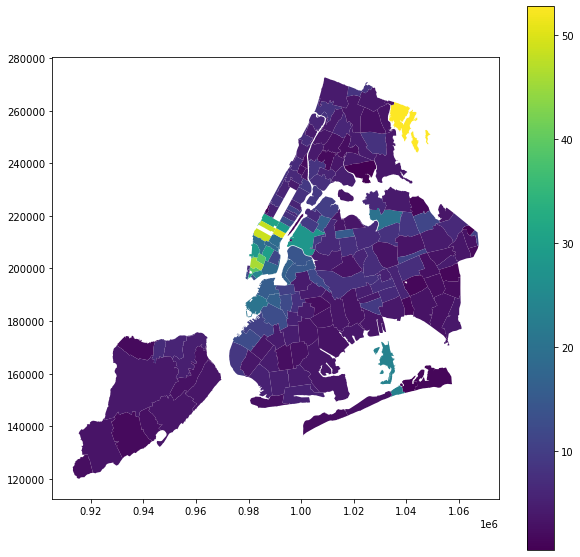

In [89]:
## normalized number of violations (per 1000 people)
data311_merge=gpd.GeoDataFrame(data311_merge)
data311_merge.plot(figsize = (10,10),column = 'normalize_violation', legend = True)

<AxesSubplot:>

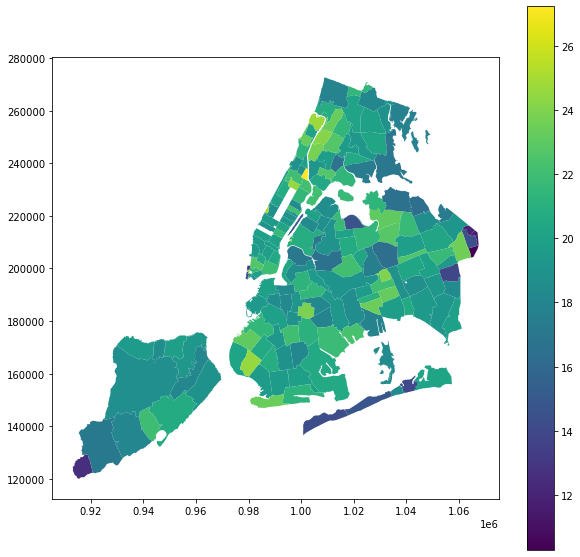

In [90]:
## average score
data311_merge.plot(figsize = (10,10),column = 'SCORE', legend = True)

<AxesSubplot:>

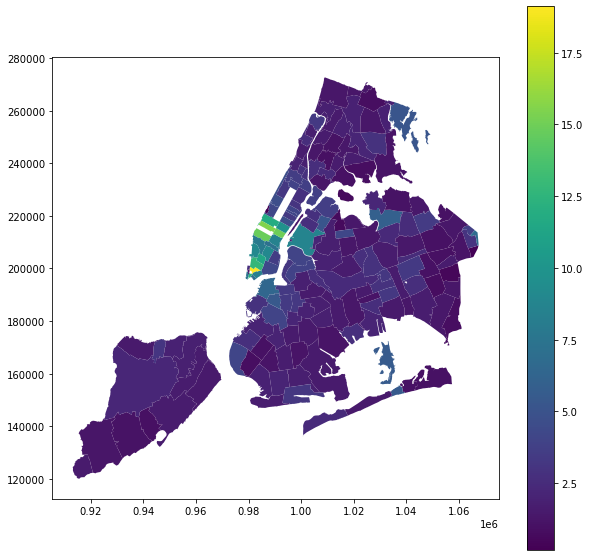

In [91]:
## normalized 311 complaints (per 1000 people)
data311_merge.plot(figsize = (10,10),column = 'normalize', legend = True)

### Perform clustering analyses by assigning each zipcode to a cluster. Use K-means clustering and choose appropriate number of clusters with average silhouette score and visualize the clusters on the map.

Take only the following features: normalized number of violations, average score and ratios for each grade for the task

These features make an approximate profile of a neighborhood in terms of the quality and performance of restaurants and food businesses present there. With clustering, we would get an idea about what areas have similar profiles and would help understand the areas where restaurants behave similarly. 

Make sure to standardize the data before clustering

In [92]:
data_cluster=data311_merge[['normalize_violation','SCORE','Grade A ratio','Grade B ratio','Grade C ratio']]
data_cluster.index=data311_merge['ZIPCODE']

In [93]:
for i in data_cluster.columns:
    data_cluster[i]=(data_cluster[i]-np.mean(data_cluster[i]))/np.std(data_cluster[i])

In [94]:
data_cluster

,normalize_violation,SCORE,Grade A ratio,Grade B ratio,Grade C ratio
ZIPCODE,,,,,
10001,3.624133,0.056778,0.138289,-0.176619,-0.403138
10002,0.849595,0.839392,-0.830025,0.422938,-0.035610
10003,1.863948,0.021224,-0.311736,0.295852,-0.177980
10005,0.428829,-0.457878,0.807304,-0.457903,-0.117219
10006,2.113231,0.202146,-0.415628,-0.480338,0.320060
...,...,...,...,...,...
11693,1.306901,-0.515878,0.886652,-0.591823,-0.888421
11693,1.306901,-0.515878,0.886652,-0.591823,-0.888421
11693,1.306901,-0.515878,0.886652,-0.591823,-0.888421


In [95]:
## perform clustring analyses

## use average silhouette score (just report the scores and choose best for number of clusters to be used)
## try with (3-15 clusters)

range_n_clusters = range(3,16)
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, random_state=123)
    cluster_labels = km.fit_predict(data_cluster)
    #report average Silhouette score
    silhouette_avg = silhouette_score(data_cluster, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))
#The best number is n_clusters equals to 5

For n_clusters =3, the average silhouette_score is :0.3143297847225499
For n_clusters =4, the average silhouette_score is :0.34530687582815217
For n_clusters =5, the average silhouette_score is :0.3481341228710195
For n_clusters =6, the average silhouette_score is :0.31432516092774215
For n_clusters =7, the average silhouette_score is :0.27630741004798975
For n_clusters =8, the average silhouette_score is :0.23962762791059108
For n_clusters =9, the average silhouette_score is :0.2589607384832391
For n_clusters =10, the average silhouette_score is :0.25136253180258633
For n_clusters =11, the average silhouette_score is :0.24573215457630493
For n_clusters =12, the average silhouette_score is :0.2535607929253197
For n_clusters =13, the average silhouette_score is :0.25423970591659645
For n_clusters =14, the average silhouette_score is :0.25941402270216907
For n_clusters =15, the average silhouette_score is :0.259291552254492


In [96]:
km = KMeans(n_clusters=5, random_state=123)
labels = km.fit_predict(data_cluster)
data_plot=data311_merge
data_plot['labels']=labels


<AxesSubplot:>

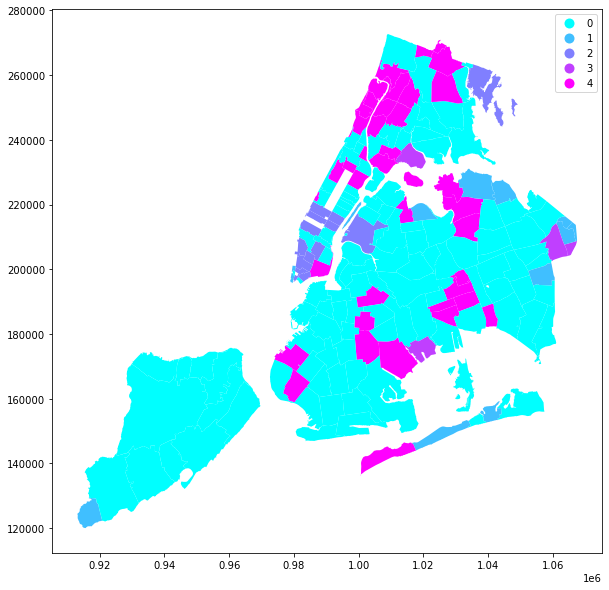

In [97]:
## plot all clustered zips in the map
data_plot['labels'] = data_plot['labels'].astype(str)
fig,ax = plt.subplots(nrows=1, ncols=1,figsize=(20,10))
data_plot.plot(column='labels',cmap='cool', 
                                    legend=True,ax=ax)

### Perform a regression analyses with normalized 311 complaints as the target and above features (normalized number of violations, average score, and ratios of 'A', 'B' and 'C' grades) as regressors. Comment on the signficance of each feature.

Include the intercept for the regression analysis. Try performing regression with each of the regressors individually (with normalized 311 complaints as target). Comment on how these regressor perform against each other. What do you think could be any problems when doing regression with all regressors together? Also comment on the coeffiecients of each regressor and whether or not they are significant.

In [98]:
lm_violation = smf.ols('normalize~normalize_violation-1', data=data311_merge).fit()
lm_violation.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              normalize   R-squared (uncentered):                   0.830
Model:                            OLS   Adj. R-squared (uncentered):              0.829
Method:                 Least Squares   F-statistic:                              917.8
Date:                Tue, 14 Dec 2021   Prob (F-statistic):                    2.94e-74
Time:                        21:20:48   Log-Likelihood:                         -378.15
No. Observations:                 189   AIC:                                      758.3
Df Residuals:                     188   BIC:                                      761.5
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
normalize_violation     0.2760      0.009     30.296      0.000       0.258       0.294
==============================================================================
Omnibus:                      140.143   Durbin-Watson:                   0.796
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2806.794
Skew:                          -2.446   Prob(JB):                         0.00
Kurtosis:                      21.234   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [99]:
lm_average = smf.ols('normalize~SCORE-1', data=data311_merge).fit()
lm_average.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              normalize   R-squared (uncentered):                   0.521
Model:                            OLS   Adj. R-squared (uncentered):              0.518
Method:                 Least Squares   F-statistic:                              204.4
Date:                Tue, 14 Dec 2021   Prob (F-statistic):                    7.28e-32
Time:                        21:20:49   Log-Likelihood:                         -476.05
No. Observations:                 189   AIC:                                      954.1
Df Residuals:                     188   BIC:                                      957.3
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
SCORE          0.1575      0.011     14.298      0.000       0.136       0.179
==============================================================================
Omnibus:                      116.420   Durbin-Watson:                   0.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              585.925
Skew:                           2.480   Prob(JB):                    5.86e-128
Kurtosis:                      10.057   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [100]:
data311_merge=data311_merge.rename(columns={"Grade A ratio": 'A_ratio', "Grade B ratio": "B_ratio",'Grade C ratio':'C_ratio'})

In [101]:
lm_gradeA = smf.ols('normalize~A_ratio-1', data=data311_merge).fit()
lm_gradeA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              normalize   R-squared (uncentered):                   0.512
Model:                            OLS   Adj. R-squared (uncentered):              0.509
Method:                 Least Squares   F-statistic:                              197.1
Date:                Tue, 14 Dec 2021   Prob (F-statistic):                    4.35e-31
Time:                        21:20:51   Log-Likelihood:                         -477.84
No. Observations:                 189   AIC:                                      957.7
Df Residuals:                     188   BIC:                                      960.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
A_ratio        7.1741      0.511     14.038      0.000       6.166       8.182
==============================================================================
Omnibus:                      115.453   Durbin-Watson:                   0.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              606.108
Skew:                           2.427   Prob(JB):                    2.43e-132
Kurtosis:                      10.308   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [102]:
lm_gradeB = smf.ols('normalize~B_ratio-1', data=data311_merge).fit()
lm_gradeB.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              normalize   R-squared (uncentered):                   0.326
Model:                            OLS   Adj. R-squared (uncentered):              0.323
Method:                 Least Squares   F-statistic:                              91.00
Date:                Tue, 14 Dec 2021   Prob (F-statistic):                    7.71e-18
Time:                        21:20:51   Log-Likelihood:                         -508.29
No. Observations:                 189   AIC:                                      1019.
Df Residuals:                     188   BIC:                                      1022.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
B_ratio       27.8283      2.917      9.539      0.000      22.074      33.583
==============================================================================
Omnibus:                       72.892   Durbin-Watson:                   0.849
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              241.934
Skew:                           1.558   Prob(JB):                     2.92e-53
Kurtosis:                       7.584   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [103]:
lm_gradeC = smf.ols('normalize~C_ratio-1', data=data311_merge).fit()
lm_gradeC.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              normalize   R-squared (uncentered):                   0.190
Model:                            OLS   Adj. R-squared (uncentered):              0.186
Method:                 Least Squares   F-statistic:                              44.05
Date:                Tue, 14 Dec 2021   Prob (F-statistic):                    3.33e-10
Time:                        21:20:52   Log-Likelihood:                         -525.70
No. Observations:                 189   AIC:                                      1053.
Df Residuals:                     188   BIC:                                      1057.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
C_ratio       41.4227      6.241      6.637      0.000      29.111      53.735
==============================================================================
Omnibus:                       66.952   Durbin-Watson:                   0.879
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              275.702
Skew:                           1.322   Prob(JB):                     1.36e-60
Kurtosis:                       8.293   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [104]:
lm = smf.ols('normalize~normalize_violation+SCORE+A_ratio+B_ratio+C_ratio-1', data=data311_merge).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              normalize   R-squared (uncentered):                   0.862
Model:                            OLS   Adj. R-squared (uncentered):              0.858
Method:                 Least Squares   F-statistic:                              229.1
Date:                Tue, 14 Dec 2021   Prob (F-statistic):                    5.17e-77
Time:                        21:20:52   Log-Likelihood:                         -358.70
No. Observations:                 189   AIC:                                      727.4
Df Residuals:                     184   BIC:                                      743.6
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
normalize_violation     0.2308      0.011     20.703      0.000       0.209       0.253
SCORE                   0.0264      0.030      0.895      0.372      -0.032       0.085
A_ratio                 1.4860      0.949      1.567      0.119      -0.385       3.357
B_ratio                -2.7135      2.893     -0.938      0.350      -8.422       2.995
C_ratio                 1.2563      3.703      0.339      0.735      -6.049       8.562
==============================================================================
Omnibus:                       58.599   Durbin-Watson:                   0.886
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1238.366
Skew:                          -0.483   Prob(JB):                    1.24e-269
Kurtosis:                      15.503   Cond. No.                         720.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

When doing regression by each regressors, they are all significant. But when doing regression together, only Violations regressors is significant 